# Model Training & Evaluation

**The collaborative filtering model will take ~90mins to run. Precalculated results are available, to use these change the 'use_saved' argument in the get_train_test_split and get_model_recs function calls to True.**

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import itertools

from models import PopularityRecommender, ColabFilteringRecommender
from eval import evaluate

Load customer product table (1 row for each customer/product combo) and create interaction matrix (1 row for each customer, 1 column for each product)

In [28]:
cptable = pd.read_csv('./data/customerproducttable.csv',engine='python')
intmat = pd.pivot_table(cptable, values='quantity', index='cid', columns='pid')
# create version of interaction matrix with NaN values filled with 0
intmat0 = pd.pivot_table(cptable, values='quantity', index='cid', columns='pid', fill_value=0)

In [3]:
cptable.head(5)

,cid,pid,quantity
0,c1,p3508,1
1,c1,p3507,1
2,c1,p315,1
3,c1,p2707,1
4,c1,p9,2


In [4]:
intmat0.head(5)

pid,p0,p1,p10,p100,p1000,p1003,p1004,p1005,p1006,p1008,...,p99,p990,p991,p992,p993,p994,p995,p997,p998,p999
cid,,,,,,,,,,,,,,,,,,,,,
c1,2,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,2,4,0
c10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
c1000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
c1001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
c1002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Test/Train Split (80/20)

We stratify by customer, removing some product interactions from each customer to use for testing, essentially picking holes in a customer's purchase history and seeing if the models can recommend iterms that they did actually buy in the test set. 

In [29]:
def get_test_train_split(cptable, use_saved=False):
    if use_saved:
        train_cp = pd.read_csv('./data/train.csv')
        test_cp = pd.read_csv('./data/test.csv')
        
        print("# rows in customer product table (ie number of customer/product interactions):")
        print(f"TRAIN:{train_cp.shape[0]} - TEST:{test_cp.shape[0]}")

    else:
        # split cptable 80/20, stratifying by customerid
        train_cp, test_cp = train_test_split(cptable,test_size=0.2,
                                             stratify=cptable[['cid']],
                                             random_state=42)
        print("# rows in customer product table (ie number of customer/product interactions):")
        print(f"TRAIN:{train_cp.shape[0]} - TEST:{test_cp.shape[0]}")
        
        train_cp.to_csv('./data/train.csv', index=False)
        test_cp.to_csv('./data/test.csv', index=False)

    train_im = pd.pivot_table(train_cp, values='quantity', index='cid', columns='pid')
    train_im0 = pd.pivot_table(train_cp, values='quantity', index='cid', columns='pid', fill_value=0)

    test_im = pd.pivot_table(test_cp, values='quantity', index='cid', columns='pid')
    test_im0 = pd.pivot_table(test_cp, values='quantity', index='cid', columns='pid', fill_value=0)

    print("# rows in interaction matrix (ie number of customers x number of products):")
    print(f"TRAIN:{train_im.shape} - TEST:{test_im.shape}")
    
    return train_cp, test_cp, train_im, train_im0, test_im, test_im0


train_cp, test_cp, train_im, train_im0, test_im, test_im0 = get_test_train_split(cptable, use_saved=True)

# rows in customer product table (ie number of customer/product interactions):
TRAIN:166796 - TEST:41700
# rows in interaction matrix (ie number of customers x number of products):
TRAIN:(2368, 2267) - TEST:(2368, 2265)


### Models

In [6]:
def get_model_recs(train, test, maxrec=20, numrec=20, use_saved=False):
    if use_saved:
        poprecs = pd.read_csv('./data/poprecs.csv')
        cbfrecs = pd.read_csv('./data/cbfrecs.csv')
    else:    
        popmodel = PopularityRecommender('Popularity Model',maxrec)
        popmodel.train(train)
        poprecs = popmodel.recommend(test.index,numrec)
        
        poprecs.to_csv('./data/poprecs.csv',index=False)

        cbfmodel = ColabFilteringRecommender('Collaborative Filtering Model',maxrec)
        cbfmodel.train(train)
        cbfrecs = cbfmodel.recommend(test.index,numrec)
        
        cbfrecs.to_csv('./data/cbfrecs.csv',index=False)
    
    return poprecs, cbfrecs

poprecs, cbfrecs = get_model_recs(train_im0, test_im, use_saved=True)

In [7]:
cbfrecs

,cid,pid,rank
0,c1,p531,1
1,c1,p448,2
2,c1,p580,3
3,c1,p2949,4
4,c1,p3031,5
...,...,...,...
47355,c998,p428,16
47356,c998,p78,17
47357,c998,p1027,18
47358,c998,p1328,19


### Evaluation

Calculate the following for each customer:
- Recall: What proportion of the items recommended were purchased - TP/(TP+FN)
- Precision: What propoprtion of the items purchased were recommended - TP/(TP+FP)
- F1 Score: 2x(Precision x Recall)/(Precision + Recall)

Where:
- True Positives: items recommended that were purchased
- False Positives: items recommended that were not purchased
- False Negatives: items not recommended that were purchased
- True Negatives: items not recommended that were not purchased

Take average Precision, Recall & F1 across all customers for a range of number of recommendations.

In [8]:
print('Evaluating Popularity Model')
pop_metrics = evaluate(poprecs, test_cp, np.linspace(1,20,20))
print('Evaluating Colab Filtering Model')
cbf_metrics = evaluate(cbfrecs, test_cp, np.linspace(1,20,20))

Evaluating Popularity Model
Evaluating at 1.0 recomendations
Evaluating at 2.0 recomendations
Evaluating at 3.0 recomendations
Evaluating at 4.0 recomendations
Evaluating at 5.0 recomendations
Evaluating at 6.0 recomendations
Evaluating at 7.0 recomendations
Evaluating at 8.0 recomendations
Evaluating at 9.0 recomendations
Evaluating at 10.0 recomendations
Evaluating at 11.0 recomendations
Evaluating at 12.0 recomendations
Evaluating at 13.0 recomendations
Evaluating at 14.0 recomendations
Evaluating at 15.0 recomendations
Evaluating at 16.0 recomendations
Evaluating at 17.0 recomendations
Evaluating at 18.0 recomendations
Evaluating at 19.0 recomendations
Evaluating at 20.0 recomendations
Evaluating Colab Filtering Model
Evaluating at 1.0 recomendations
Evaluating at 2.0 recomendations
Evaluating at 3.0 recomendations
Evaluating at 4.0 recomendations
Evaluating at 5.0 recomendations
Evaluating at 6.0 recomendations
Evaluating at 7.0 recomendations
Evaluating at 8.0 recomendations
Eval

In [21]:
pop4 = pop_metrics[pop_metrics['k']==4].iloc[0].to_dict()
cbf4 = cbf_metrics[cbf_metrics['k']==4].iloc[0].to_dict()
print('At 4 recommendations:')
print(f"             Avg Precision        Avg Recall        Avg F1")
print(f"Popularity:  {pop4['precision']:.4f}               {pop4['recall']:.4f}            {pop4['f1']:.4f}")
print(f"CBF:         {cbf4['precision']:.4f}               {cbf4['recall']:.4f}            {cbf4['f1']:.4f}")
print(f"Increase:    {100*((cbf4['precision']-pop4['precision'])/pop4['precision']):.0f}%                  {100*((cbf4['recall']-pop4['recall'])/pop4['recall']):.0f}%              {100*((cbf4['f1']-pop4['f1'])/pop4['f1']):.0f}%")

At 4 recommendations:
             Avg Precision        Avg Recall        Avg F1
Popularity:  0.0702               0.0177            0.0283
CBF:         0.1290               0.0369            0.0574
Increase:    84%                  108%              103%


#### METRICS LINE GRAPH

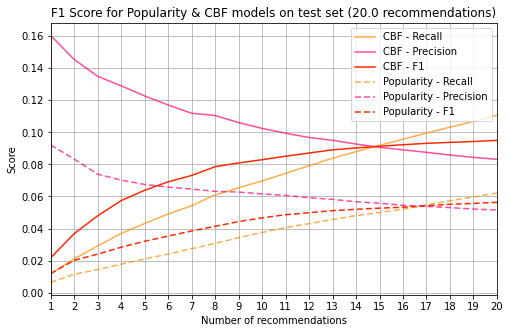

In [23]:
# Plot line chart

colors = ['#fc8c03','#fc036f','#fc2803']
x = cbf_metrics['k']
fig = plt.figure(figsize=(8,5))

plt.plot(x,cbf_metrics['recall'], label='CBF - Recall', color=colors[0], alpha=0.7)
plt.plot(x,cbf_metrics['precision'], label='CBF - Precision', color=colors[1], alpha=0.7)
plt.plot(x,cbf_metrics['f1'], label='CBF - F1', color=colors[2])

plt.plot(x,pop_metrics['recall'], label='Popularity - Recall', color=colors[0], linestyle="--", dashes=(4,2), alpha=0.7)
plt.plot(x,pop_metrics['precision'], label='Popularity - Precision', color=colors[1], linestyle="--", dashes=(4,2), alpha=0.7)
plt.plot(x,pop_metrics['f1'], label='Popularity - F1', color=colors[2], linestyle="--", dashes=(4,2))

plt.xticks(x)
plt.xlim(1,max(x))
plt.xlabel('Number of recommendations')
plt.ylabel('Score')
plt.title(f'F1 Score for Popularity & CBF models on test set ({max(x)} recommendations)')
plt.grid()
plt.legend()
plt.show()

#### CHANGE IN F1 SCORE GRAPH

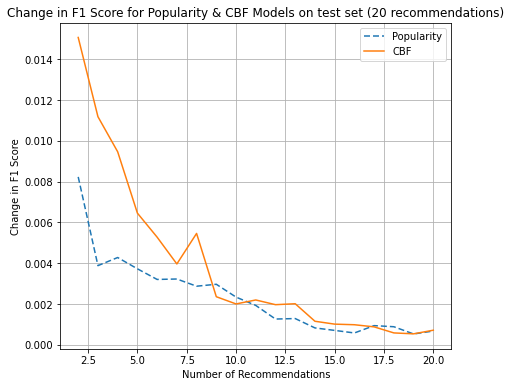

In [26]:
# Plot change in F1 score chart

x = cbf_metrics['k'].astype(int).tolist()[1:]
fig = plt.figure(figsize=(7,6))

popf1 = pop_metrics['f1'].tolist()
cbff1 = cbf_metrics['f1'].tolist()

pop_f1_delta = [popf1[i]-popf1[i-1] for i in range(1,max(x))]
cbf_f1_delta = [cbff1[i]-cbff1[i-1] for i in range(1,max(x))]

plt.plot(x, pop_f1_delta, label='Popularity', linestyle="--", dashes=(4,2))
plt.plot(x, cbf_f1_delta, label='CBF')

plt.xlabel('Number of Recommendations')
plt.ylabel('Change in F1 Score')
plt.title(f'Change in F1 Score for Popularity & CBF Models on test set ({max(x)} recommendations)')
plt.grid()
plt.legend()
plt.show()